# Palmer Penguins Tidy Tuesday
## or my attempt to compare linear and multi-level models in an hour

Wow! Here we are attempting a Tidy Tuesday. This is a real long time listener, first time caller situation. My plan is to follow the [instructions](https://github.com/rfordatascience/tidytuesday/blob/main/data/2025/2025-04-15/readme.md) on the Posit git repo for loading the data and then get to work!

In [1]:
# load our libraries
import pandas as pd # for EDA and importing
import numpy as np # so pandas actually works
import seaborn as sns # for viz
import matplotlib.pyplot as plt # also for viz
import statsmodels.api as sm # for modeling
import os # we need to disable MKL for annoying python reasons
os.environ["MKL_THREADING_LAYER"] = "GNU"
import bambi as bmb # for Bayesian multi-level models
import arviz as az # for model viz
from matplotlib import colormaps
import matplotlib.font_manager as font_manager # font fixes


# Load in our data from the Tidy Tuesday git repo:

penguins = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2025/2025-04-15/penguins.csv')

# let's update the sex column to numeric
penguins['sex'] = penguins['sex'].map({'male': 0, 'female': 1})


Ok, let's just take a look at the basic relationships between our columns with my favorite EDA plot, the correlogram (a word I have only ever read and fear for the day I have to read out loud).


/Users/jacobpstein/opt/anaconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


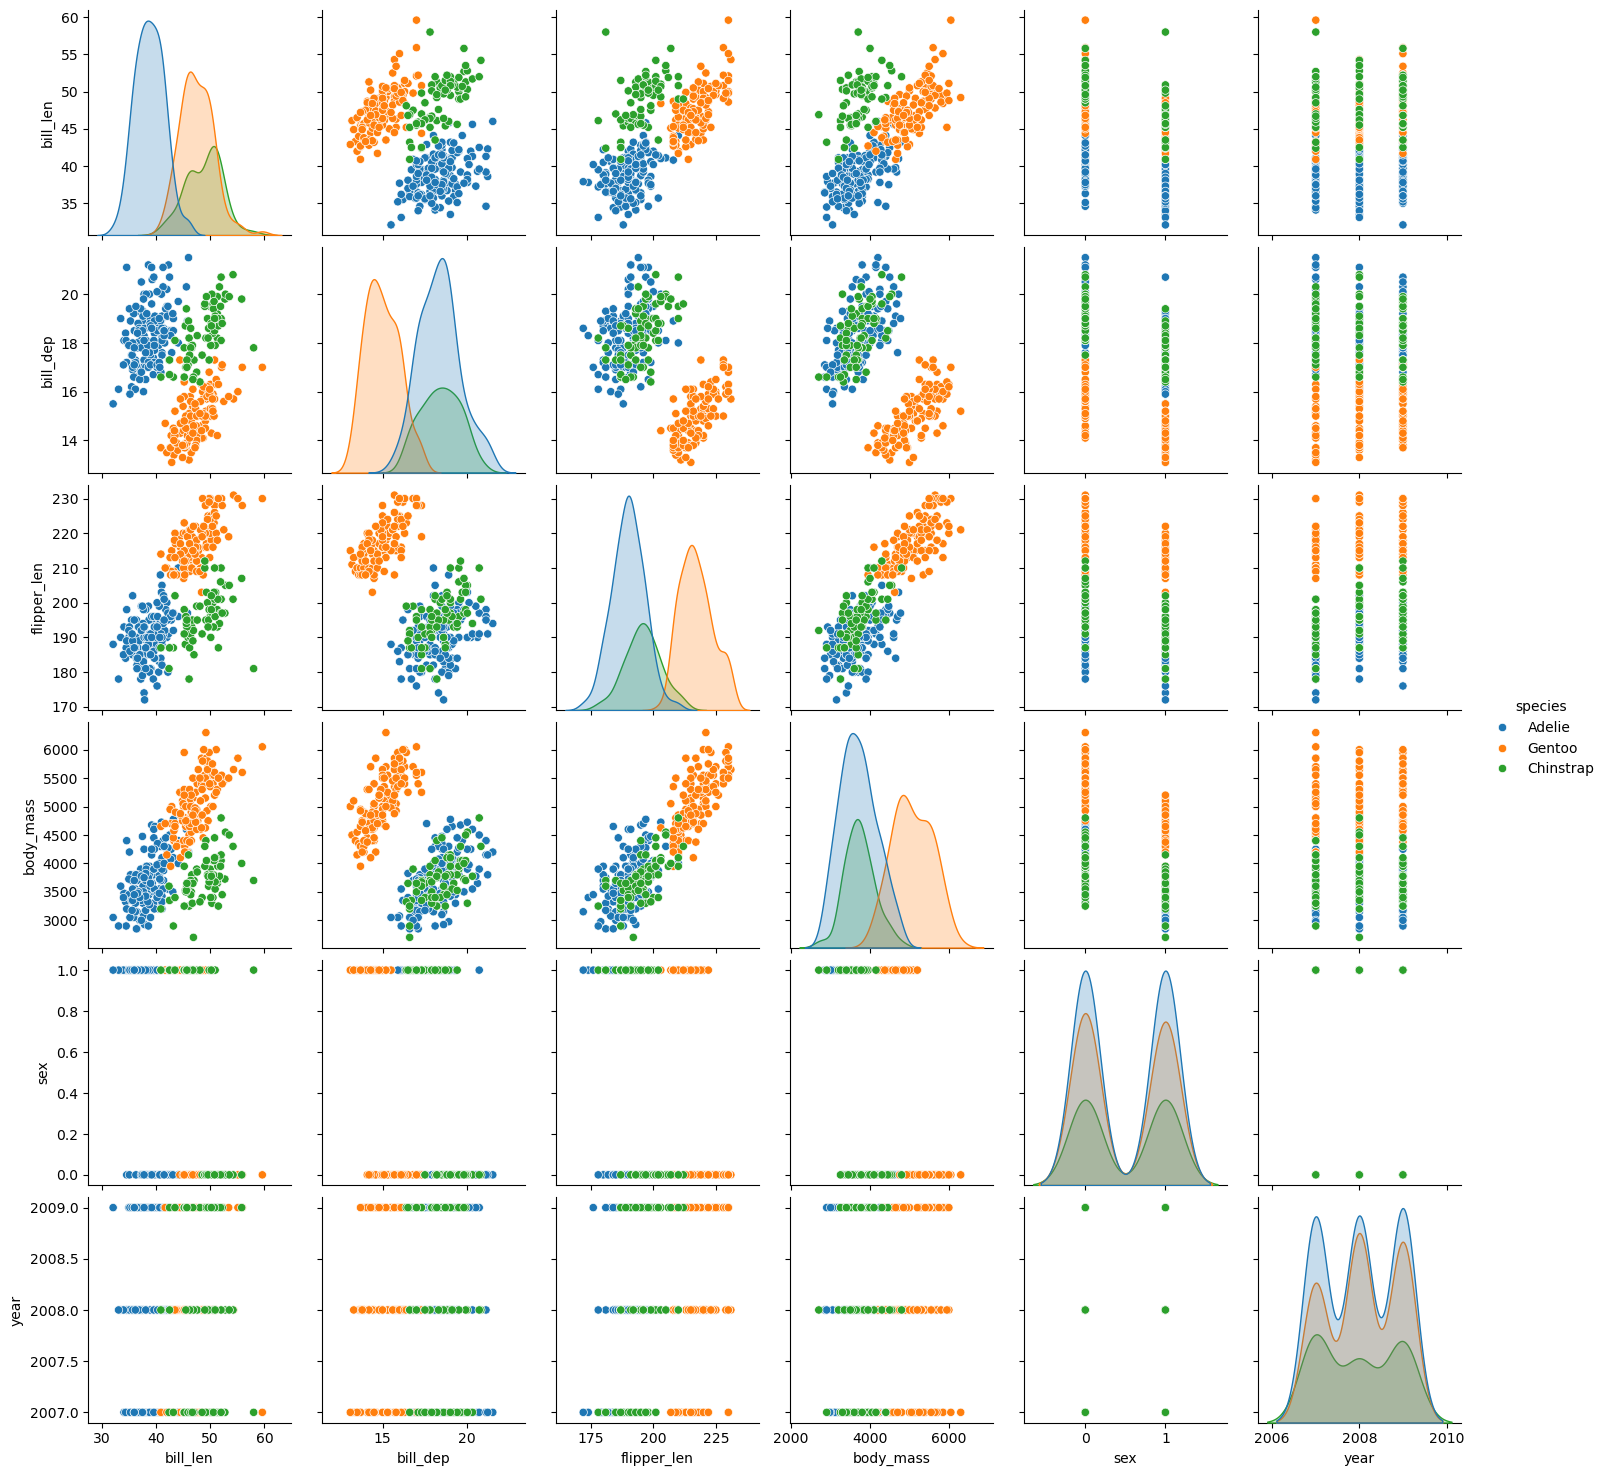

In [2]:
# Basic correlogram
sns.pairplot(penguins, kind="scatter", hue="species")
plt.show()

and let's put some numbers behind that figure

In [3]:
penguins.drop(columns=['species', 'island']).corr()
# we have to drop the text columns

,bill_len,bill_dep,flipper_len,body_mass,sex,year
bill_len,1.000000,-0.235053,0.656181,0.595110,-0.344078,0.054545
bill_dep,-0.235053,1.000000,-0.583851,-0.471916,-0.372673,-0.060354
flipper_len,0.656181,-0.583851,1.000000,0.871202,-0.255169,0.169675
body_mass,0.595110,-0.471916,0.871202,1.000000,-0.424987,0.042209
sex,-0.344078,-0.372673,-0.255169,-0.424987,1.000000,0.000467
year,0.054545,-0.060354,0.169675,0.042209,0.000467,1.000000


Ok, so we see that flipper length and body mass are really, highly correlated. There's a pretty good relationship with bill length too, and it looks like female penguins tend to have lower mass and smaller bill and flipper lengths. 

### Model time!

In [4]:
# There are 11 missing values from the sex column. If this weren't a Tidy Tuesday, we might do more work to see what's going on with those, but for now, let's power ahead and drop them for our model

penguins_no_na = penguins.dropna()

# fit a simple linear model to estimate the relationship between flipper length and body mass

X = sm.add_constant(penguins_no_na['flipper_len'])
y = penguins_no_na['body_mass']
model_simple = sm.OLS(y, X).fit()

# The summary basically tells us what we saw from the correlation matrix
print(model_simple.summary())

                            OLS Regression Results                            
Dep. Variable:              body_mass   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1060.
Date:                Thu, 17 Apr 2025   Prob (F-statistic):          3.13e-105
Time:                        08:38:23   Log-Likelihood:                -2461.1
No. Observations:                 333   AIC:                             4926.
Df Residuals:                     331   BIC:                             4934.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -5872.0927    310.285    -18.925      

But we know there is some variation by species and island, so let's add that in the model and allow our intercept and slope to vary accordingly

In [ ]:
# fit a mixed model
model_mixed = bmb.Model("body_mass ~ flipper_len + (1 + flipper_len | species) + (1 | island)", data=penguins_no_na)

# let's explain this because it's helpful for both python and R:
# we want flipper length as a fixed effect (a consistent relationship across all penguins), but we also know that 
# the relationship between flipper length and body mass may vary by species

# (1 + flipper_len | species) means that both the intercept ("1") and the slope for flipper length can vary randomly by species 
# Essentially, each penguin species might have its own unique relationship between flipper length and body mass
# (1 | island) means that only the intercept varies by island. Penguin body mass might differ between islands
# but the relationship between flipper length and body mass is probably the same across islands. But who knows, this could be an area
# for more exploration

fitted_mixed = model_mixed.fit(draws=1000, chains=2, cores=2)



It looks like basic OLS is overstating the flipper-body mass association because it ignores species-specific variation.


In [ ]:

# Now that we've fit a model to the data to account for variation at different levels in our slopes and intercepts, let's pull those values out so we can use them for graphing
posterior = fitted_mixed.posterior
intercept_global = posterior["Intercept"].mean().item()
slope_global = posterior["flipper_len"].mean().item()
species_levels = penguins_no_na['species'].astype('category').cat.categories.tolist()
intercept_species = posterior["1|species"].mean(dim=["chain", "draw"]).values
slope_species = posterior["flipper_len|species"].mean(dim=["chain", "draw"]).values

# Create some prediction lines
flipper_grid = np.linspace(penguins_no_na["flipper_len"].min(), penguins_no_na["flipper_len"].max(), 100)
species_lines = []
for i, species in enumerate(species_levels):
    intercept = intercept_global + intercept_species[i]
    slope = slope_global + slope_species[i]
    y_vals = intercept + slope * flipper_grid
    species_lines.append((species, flipper_grid, y_vals))

# Add some nice colors and fonts
# hex colors for species, I took these from https://www.color-hex.com/color-palette/1058331
custom_colors = {
    "Adelie": "#5b6f95",
    "Chinstrap": "#e85f1c",
    "Gentoo": "#8cc3c7"
}

# Set font to Gill Sans
plt.rcParams["font.family"] = "Gill Sans"

# Graph the thing
for species, color in custom_colors.items():
    subset = penguins_no_na[penguins_no_na["species"] == species]
    plt.scatter(subset["flipper_len"], subset["body_mass"], alpha=0.5, color=color, label=None)

# Simple regression line (dashed)
simple_intercept = model_simple.params['const']
simple_slope = model_simple.params['flipper_len']
y_simple = simple_intercept + simple_slope * flipper_grid
plt.plot(flipper_grid, y_simple, linestyle='--', color='black', linewidth=2, label='Simple Model--All speciies')

# Multilevel regression lines
for (species, x_vals, y_vals) in species_lines:
    plt.plot(x_vals, y_vals, color=custom_colors[species], linewidth=2, label=f'Multilevel: {species}')

# Labels and legend
plt.xlabel("Flipper Length")
plt.ylabel("Body Mass")
plt.title("Simple vs Multilevel Regression: A Tidy Tuesday Journey", fontsize=16)
plt.legend(title="Model", fontsize=10, title_fontsize=12)
plt.tight_layout()

# Save figure
plt.savefig("simple_vs_multilevel_penguins.png", dpi=300)
plt.show()

Every model abstracts in some way, or to add my own abstraction--fitting a model to data is a blunt tool for understanding the world. But the point of this exercise is to see how accounting for the variation in our data by species and island (though as the table shows, this was less informative) makes the model a slightly better tool than assuming a very basic linear relationship.